In [1]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

import utils

In [2]:
tracks = utils.load('/Users/ivankwist/Downloads/fma_metadata/tracks.csv')
features = utils.load('/Users/ivankwist/Downloads/fma_metadata/features.csv')

In [3]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']
tracks = tracks.loc[subset]
features = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']
labels = tracks['track', 'genre_top']

# Split in training, validation and testing sets.
y_train = labels[train]
y_val = labels[val]
y_test = labels[test]
X_train = features.loc[train].as_matrix()
X_val = features.loc[val].as_matrix()
X_test = features.loc[test].as_matrix()

X_train, y_train = shuffle(X_train, y_train, random_state=25)

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


array([[ 0.1253238 ,  0.59807614, -0.10177305, ..., -0.10643952,
        -0.8105098 , -0.84468934],
       [-0.34768999, -0.35213792, -0.0645586 , ..., -0.51699423,
        -0.23005883,  1.11347606],
       [-0.0231874 , -0.03538058, -0.03524516, ..., -0.51699423,
         0.08205794,  0.54353052],
       ...,
       [-0.47744417, -0.39346363, -0.15097715, ..., -0.31171687,
         0.04967999,  2.57694115],
       [-0.52918994, -0.47181669, -0.1345473 , ..., -0.10643952,
         1.22919953,  1.71213092],
       [-0.46718922, -0.3620704 , -0.06173892, ...,  1.33050197,
        -0.01398353,  3.47595249]])

In [4]:
#https://stats.stackexchange.com/questions/260754/better-performance-using-random-forest-one-vs-all-than-random-forest-multiclass#:~:text=Since%20Random%20Forest%20can%20inherently,accuracy%20of%2079.5%20%C2%B1%200.3.
model_to_set = OneVsRestClassifier(RandomForestClassifier())

parameters = {
    "estimator__n_estimators": [25, 50, 100],
    "estimator__max_features":['auto', 'sqrt', 'log2']
}

In [5]:
gs = GridSearchCV(model_to_set, param_grid=parameters, verbose = 10, cv = 2, n_jobs = -1)

In [6]:
gs_results = gs.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.2min finished


In [7]:
gs_results.best_params_

{'estimator__max_features': 'sqrt', 'estimator__n_estimators': 100}

In [8]:
score_gs = gs_results.score(X_test, y_test)
print(score_gs)

0.475


In [9]:
y_pred = gs_results.predict(X_test)

In [10]:
cf_matrix = confusion_matrix(y_test, y_pred)

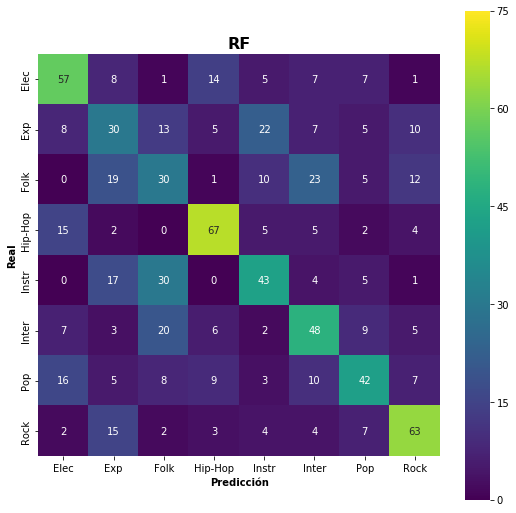

In [11]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cf_matrix, cmap='viridis', vmin=0, vmax=75, square=True, annot=True)

ticks_labels = ['Elec', 'Exp', 'Folk', 'Hip-Hop', 'Instr', 'Inter', 'Pop', 'Rock']
plt.xticks(np.arange(8) + .5, labels=ticks_labels, fontsize = 10)
plt.yticks(np.arange(8) + .5, labels=ticks_labels, va="center", fontsize = 10)

plt.title('RF', fontsize = 16, weight='bold')
plt.xlabel('Predicción', weight='bold')
plt.ylabel('Real', weight='bold')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('fig-RF.png', dpi=400, bbox_inches='tight')
plt.show()

In [12]:
pca = PCA(n_components = 0.97)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
gs_results_pca = gs.fit(X_train_pca, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.1min finished


In [14]:
gs_results_pca.best_params_

{'estimator__max_features': 'auto', 'estimator__n_estimators': 100}

In [15]:
score_gs_pca = gs_results_pca.score(X_test_pca, y_test)
print(score_gs_pca)

0.4025


In [16]:
y_pred_pca = gs_results.predict(X_test_pca)

In [17]:
cf_matrix_pca = confusion_matrix(y_test, y_pred_pca)

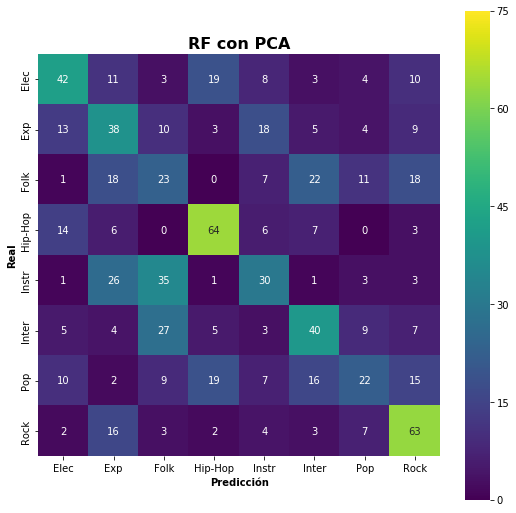

In [18]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cf_matrix_pca, cmap='viridis', vmin=0, vmax=75, square=True, annot=True)

ticks_labels = ['Elec', 'Exp', 'Folk', 'Hip-Hop', 'Instr', 'Inter', 'Pop', 'Rock']
plt.xticks(np.arange(8) + .5, labels=ticks_labels, fontsize = 10)
plt.yticks(np.arange(8) + .5, labels=ticks_labels, va="center", fontsize = 10)

plt.title('RF con PCA', fontsize = 16, weight='bold')
plt.xlabel('Predicción', weight='bold')
plt.ylabel('Real', weight='bold')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('fig-RF-PCA.png', dpi=400, bbox_inches='tight')
plt.show()